<a href="https://colab.research.google.com/github/ysedurepo/deep_learning/blob/main/CNN_transfert_learning_projet1_facial_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-Regression learning
Imaginez un scénario dans lequel on vous demande de prédire les points clés présents sur une image d’un visage ; par exemple, la position des yeux, du nez et du menton. Dans ce cas, nous devons employer une nouvelle stratégie pour construire un modèle capable de détecter ces points clés.

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

In [ ]:
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')
data.head()

In [ ]:
len(data)

In [ ]:
img_path = 'P1_Facial_Keypoints/data/training/' + data.iloc[0,0]
img = cv2.imread(img_path)/255.
img.shape

In [ ]:
kpp = deepcopy(data.iloc[0,1:].tolist())
print(kpp)
kp_x = (np.array(kpp[0::2])).tolist()
kp_y = (np.array(kpp[1::2])).tolist()
print(kp_x)
print(kp_y)
print(kp_x + kp_y)

In [ ]:
#Dataset
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def __len__(self):
      return len(self.df)

  def __getitem__(self, ix):
      img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
      img = cv2.imread(img_path)/255.
      kp = deepcopy(self.df.iloc[ix,1:].tolist())
      kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
      kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
      kp2 = kp_x + kp_y
      kp2 = torch.tensor(kp2)
      img = self.preprocess_input(img)
      return img,kp2

  def preprocess_input(self, img):
      img = cv2.resize(img, (224,224))
      img = torch.tensor(img).permute(2,0,1)
      img = self.normalize(img).float()
      return img.to(device)

  def load_img(self, ix):
      img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
      img = cv2.resize(img, (224,224))
      return img

In [ ]:
#Split the Data
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
    model.avgpool = nn.Sequential(nn.Conv2d(512,512,3),
    nn.MaxPool2d(2),nn.Flatten())
    model.classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
    )
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [ ]:
model, criterion, optimizer = get_model()

In [ ]:
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def validate_batch(img, kps, model, criterion):
  model.eval()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss

In [52]:
train_loss, test_loss = [], []
n_epochs = 50
for epoch in range(n_epochs):
  print(f" epoch {epoch+ 1} : 50")
  epoch_train_loss, epoch_test_loss = 0, 0
  for ix, (img,kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, criterion)
    epoch_train_loss += loss.item()
  epoch_train_loss /= (ix+1)
  for ix,(img,kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, criterion)
    epoch_test_loss += loss.item()
  epoch_test_loss /= (ix+1)
  print(f"train loss : {epoch_train_loss} test loss : {epoch_test_loss}")
  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)

 epoch 1 : 50
train loss : 0.054496808384341754 test loss : 0.027336192232641308
 epoch 2 : 50
train loss : 0.03458417560262927 test loss : 0.020661718127402393
 epoch 3 : 50
train loss : 0.02816505946390245 test loss : 0.017206908118995754
 epoch 4 : 50
train loss : 0.024635145055322813 test loss : 0.01427173466336998
 epoch 5 : 50
train loss : 0.022169280518916833 test loss : 0.012702942063862627
 epoch 6 : 50
train loss : 0.019796260943015415 test loss : 0.013121244412931528
 epoch 7 : 50
train loss : 0.0186706669414523 test loss : 0.011579738548872147
 epoch 8 : 50
train loss : 0.017946448155689514 test loss : 0.011418769728731026
 epoch 9 : 50
train loss : 0.016971485057695843 test loss : 0.011019012552093376
 epoch 10 : 50
train loss : 0.016249724760137755 test loss : 0.011013911740685051
 epoch 11 : 50
train loss : 0.016080688149935896 test loss : 0.010552100498567928
 epoch 12 : 50
train loss : 0.015587568143917912 test loss : 0.010615742892365564
 epoch 13 : 50
train loss : 0.

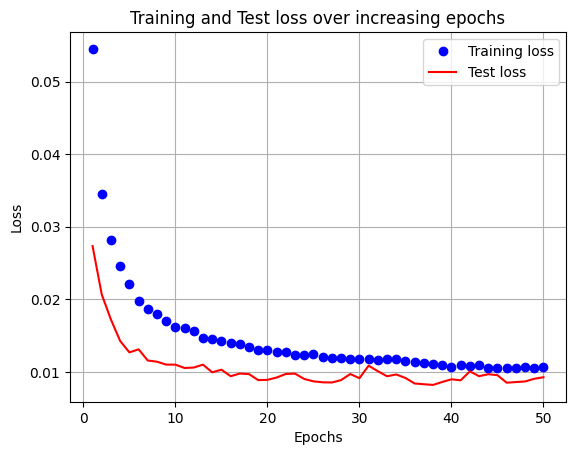

In [67]:
#Plotting Losses
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

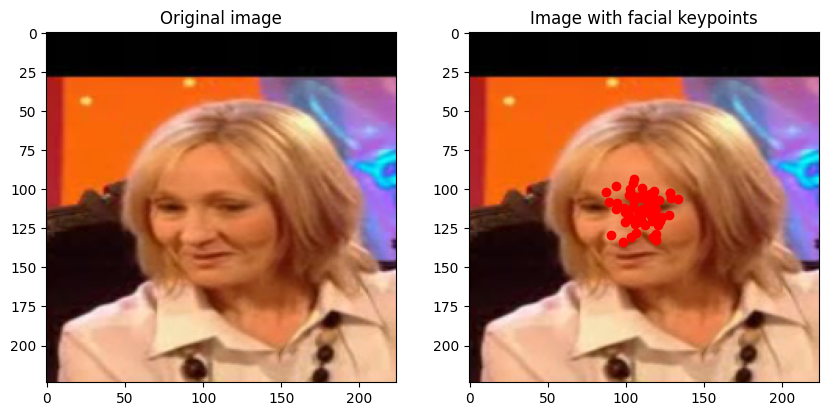

In [68]:
#Test the model
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()